In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import gc
import time
import copy
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from pathlib import Path
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from sklearn.metrics import classification_report
from utils.tcia_utils import *


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device:{device}')


# Hyperparameters
SEED = 47
NUM_SLICES = 3
BATCHSIZE = 16
IMG_SIZE = 512

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


data_dir = '../TCIA_SUBSET_4'
files_dir = 'utils/subset_paths_files'
model_name = 'MOC_ResNet18_SS1_5CLS_scratch'

!ls {data_dir}

device:cuda:0
ABDOMEN  BLADDER  CHEST  COLON	HEADNECK  KIDNEY  MEDIASTINUM  PANCREAS


In [3]:
!ls {files_dir}

subset_1_paths.pkl  subset_3_paths.pkl	subset_5_paths.pkl
subset_2_paths.pkl  subset_4_paths.pkl


### Dataset loader class

In [4]:
subset_filepath = os.path.join(files_dir, 'subset_4_paths.pkl')
pipeline = TCIA_dataset_pipeline5(data_dir, subset_filepath, IMG_SIZE, NUM_SLICES, seed=SEED)

[# TRAIN series]: ABDOMEN = 62, BLADDER = 35, CHEST = 325, COLON = 245, HEADNECK = 245, KIDNEY = 161, MEDIASTINUM = 14, PANCREAS = 13, 
[# VAL series]: ABDOMEN = 10, BLADDER = 3, CHEST = 40, COLON = 30, HEADNECK = 21, KIDNEY = 24, MEDIASTINUM = 2, PANCREAS = 1, 
[# TEST series]: ABDOMEN = 8, BLADDER = 4, CHEST = 40, COLON = 31, HEADNECK = 28, KIDNEY = 16, MEDIASTINUM = 2, PANCREAS = 2, 


In [5]:
pipeline.classes

{'HEADNECK': 0, 'LUNG': 1, 'ABDOMEN': 2, 'COLON': 3, 'BLADDER': 4}

### Visualization

In [6]:
# model savepath settings
savepath = Path(model_name+str('_chkpt'))
savepath.mkdir(parents=True, exist_ok=True)
savepath = savepath/Path(model_name+'_weights.pt')
print(savepath)
print()

# MODEL
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(pipeline.classes))
model.avgpool = nn.AdaptiveAvgPool2d((1,1))
print(model)

if savepath.exists():
    print('\n', '>'*10, 'Loading saved model...', '\n')
    model.load_state_dict(torch.load(savepath, map_location=device))

model.eval();

MOC_ResNet18_SS1_5CLS_scratch_chkpt/MOC_ResNet18_SS1_5CLS_scratch_weights.pt

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

In [7]:
# MinMax
def mm(arr):
    _min = arr.min()
    _max = arr.max()
    return (arr - _min) / (_max - _min)

### Conv 1 layer filters
Trained from scratch. These weights look random. It may be because classification is simple enough that it doesn't need to change them much. Secondly, training ran for 5 epochs only.

(64, 3, 7, 7)


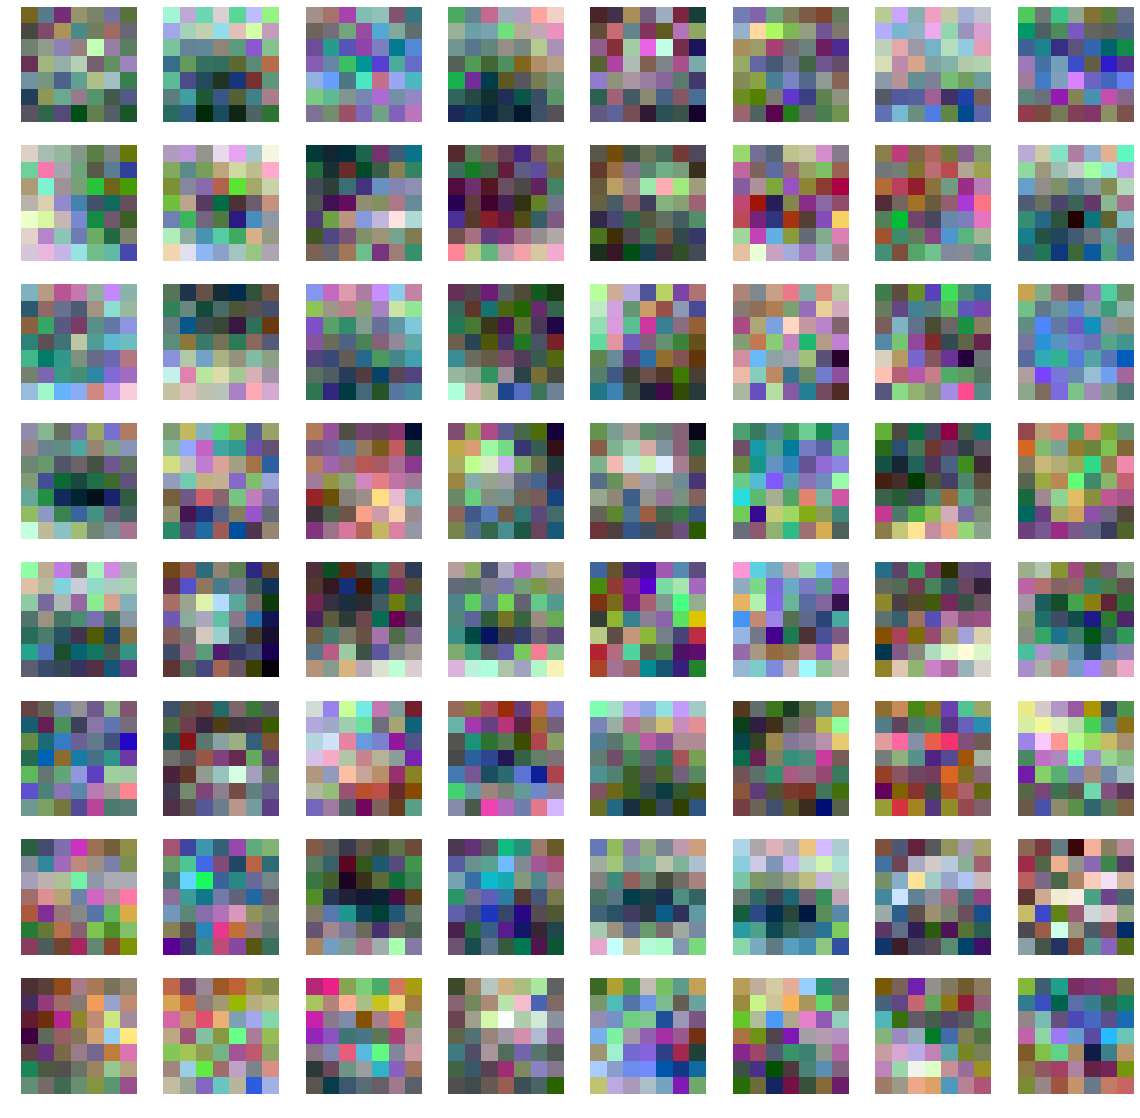

In [8]:
fig, axes = plt.subplots(8,8, figsize=(20,20))
fls = model.state_dict()['conv1.weight'].numpy()
print(fls.shape)
for idx, ax in enumerate(axes.flat):
    ax.imshow(mm(fls[idx]).transpose(1,2,0))
    ax.axis('off')

(64, 64, 3, 3)


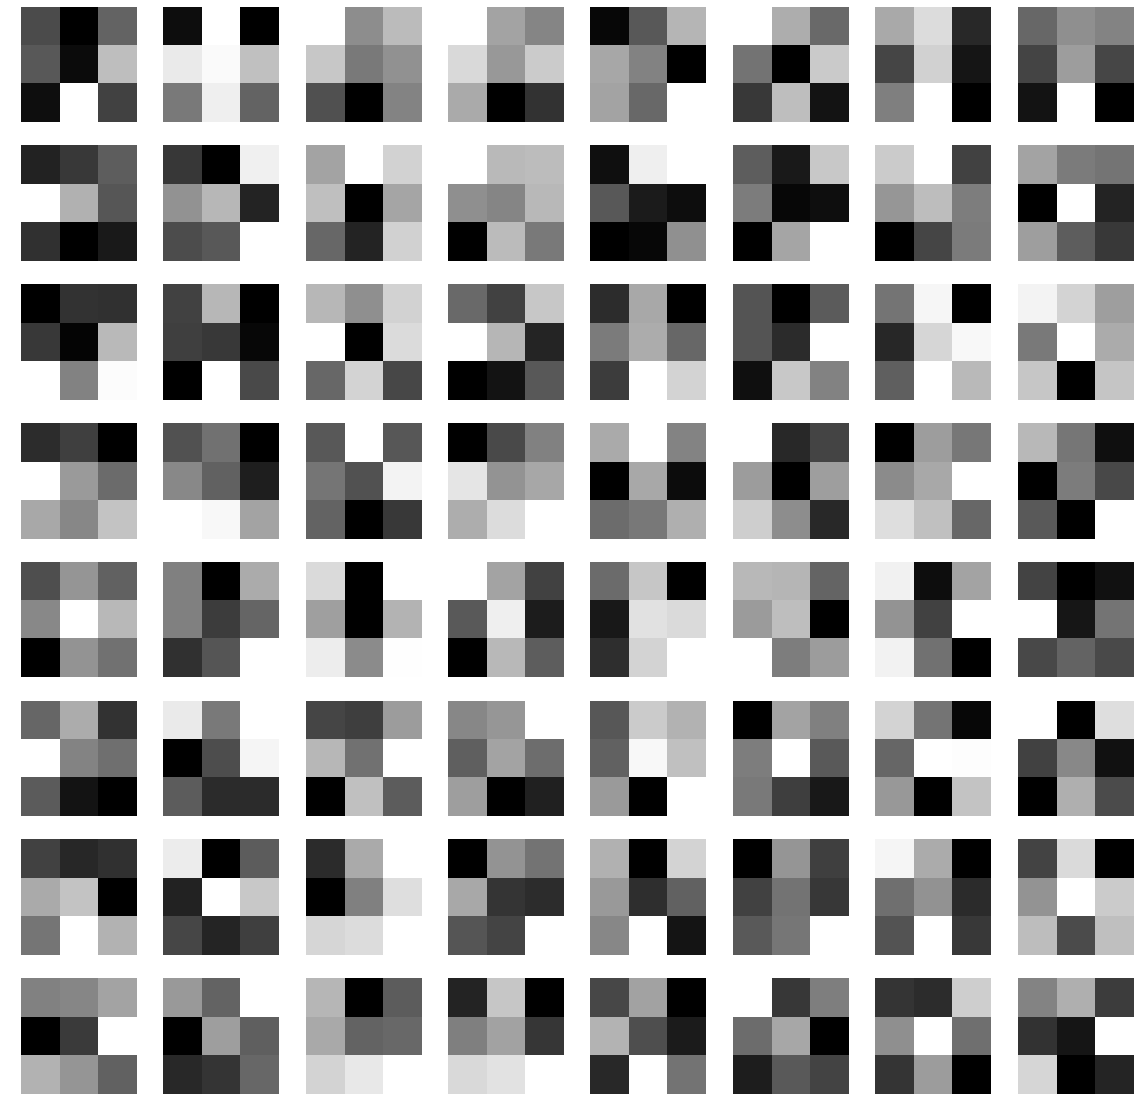

In [9]:
fig, axes = plt.subplots(8,8, figsize=(20,20))
fls = model.state_dict()['layer1.0.conv1.weight'].numpy()
print(fls.shape)
for idx, ax in enumerate(axes.flat):
    ax.imshow(mm(fls[idx,idx,...]), cmap='gray')
    ax.axis('off')

### Vis feat maps

../TCIA_SUBSET_4/COLON/1.3.6.1.4.1.9328.50.4.0003/01-01-2000-1-Abdomen24ACRINColoIRB2415-04 Adult-.2319/2-Colosupine  1.0  B30f-.3114


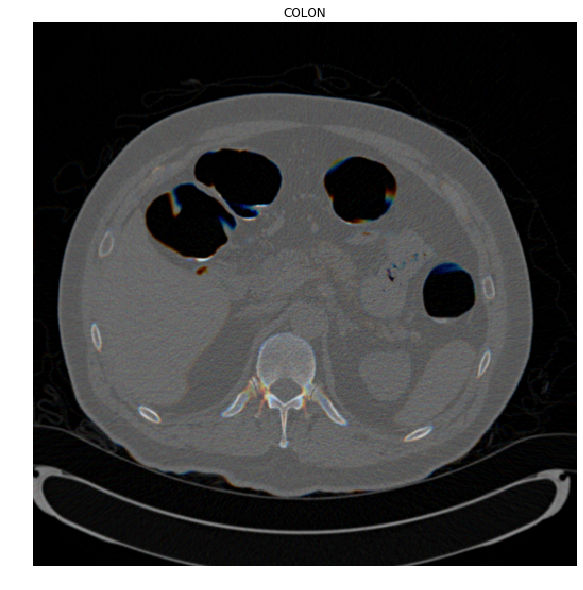

(3, 512, 512) COLON 0.9215385


In [10]:
testpath = pipeline.paths_dict['test']['COLON'][2]
testpath = testpath.replace('../../TCIA_DATA', data_dir)
print(testpath)

data = await pipeline.load_dicom_files(testpath)
testsample, testlabel = data[0]
testimg = testsample[:3,...]
plt.figure(figsize=(10,10))
plt.imshow(testimg.transpose(1,2,0))
plt.title(testlabel)
plt.axis('off')
plt.show()
print(testimg.shape, testlabel, testimg.max())
testimg = torch.tensor(np.expand_dims(testimg, 0))

In [11]:
out = model(testimg)
torch.max(F.softmax(out, 1), 1)

(tensor([0.9945], grad_fn=<MaxBackward0>), tensor([3]))

In [12]:
model.layer1

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

### conv1

torch.Size([1, 64, 128, 128])


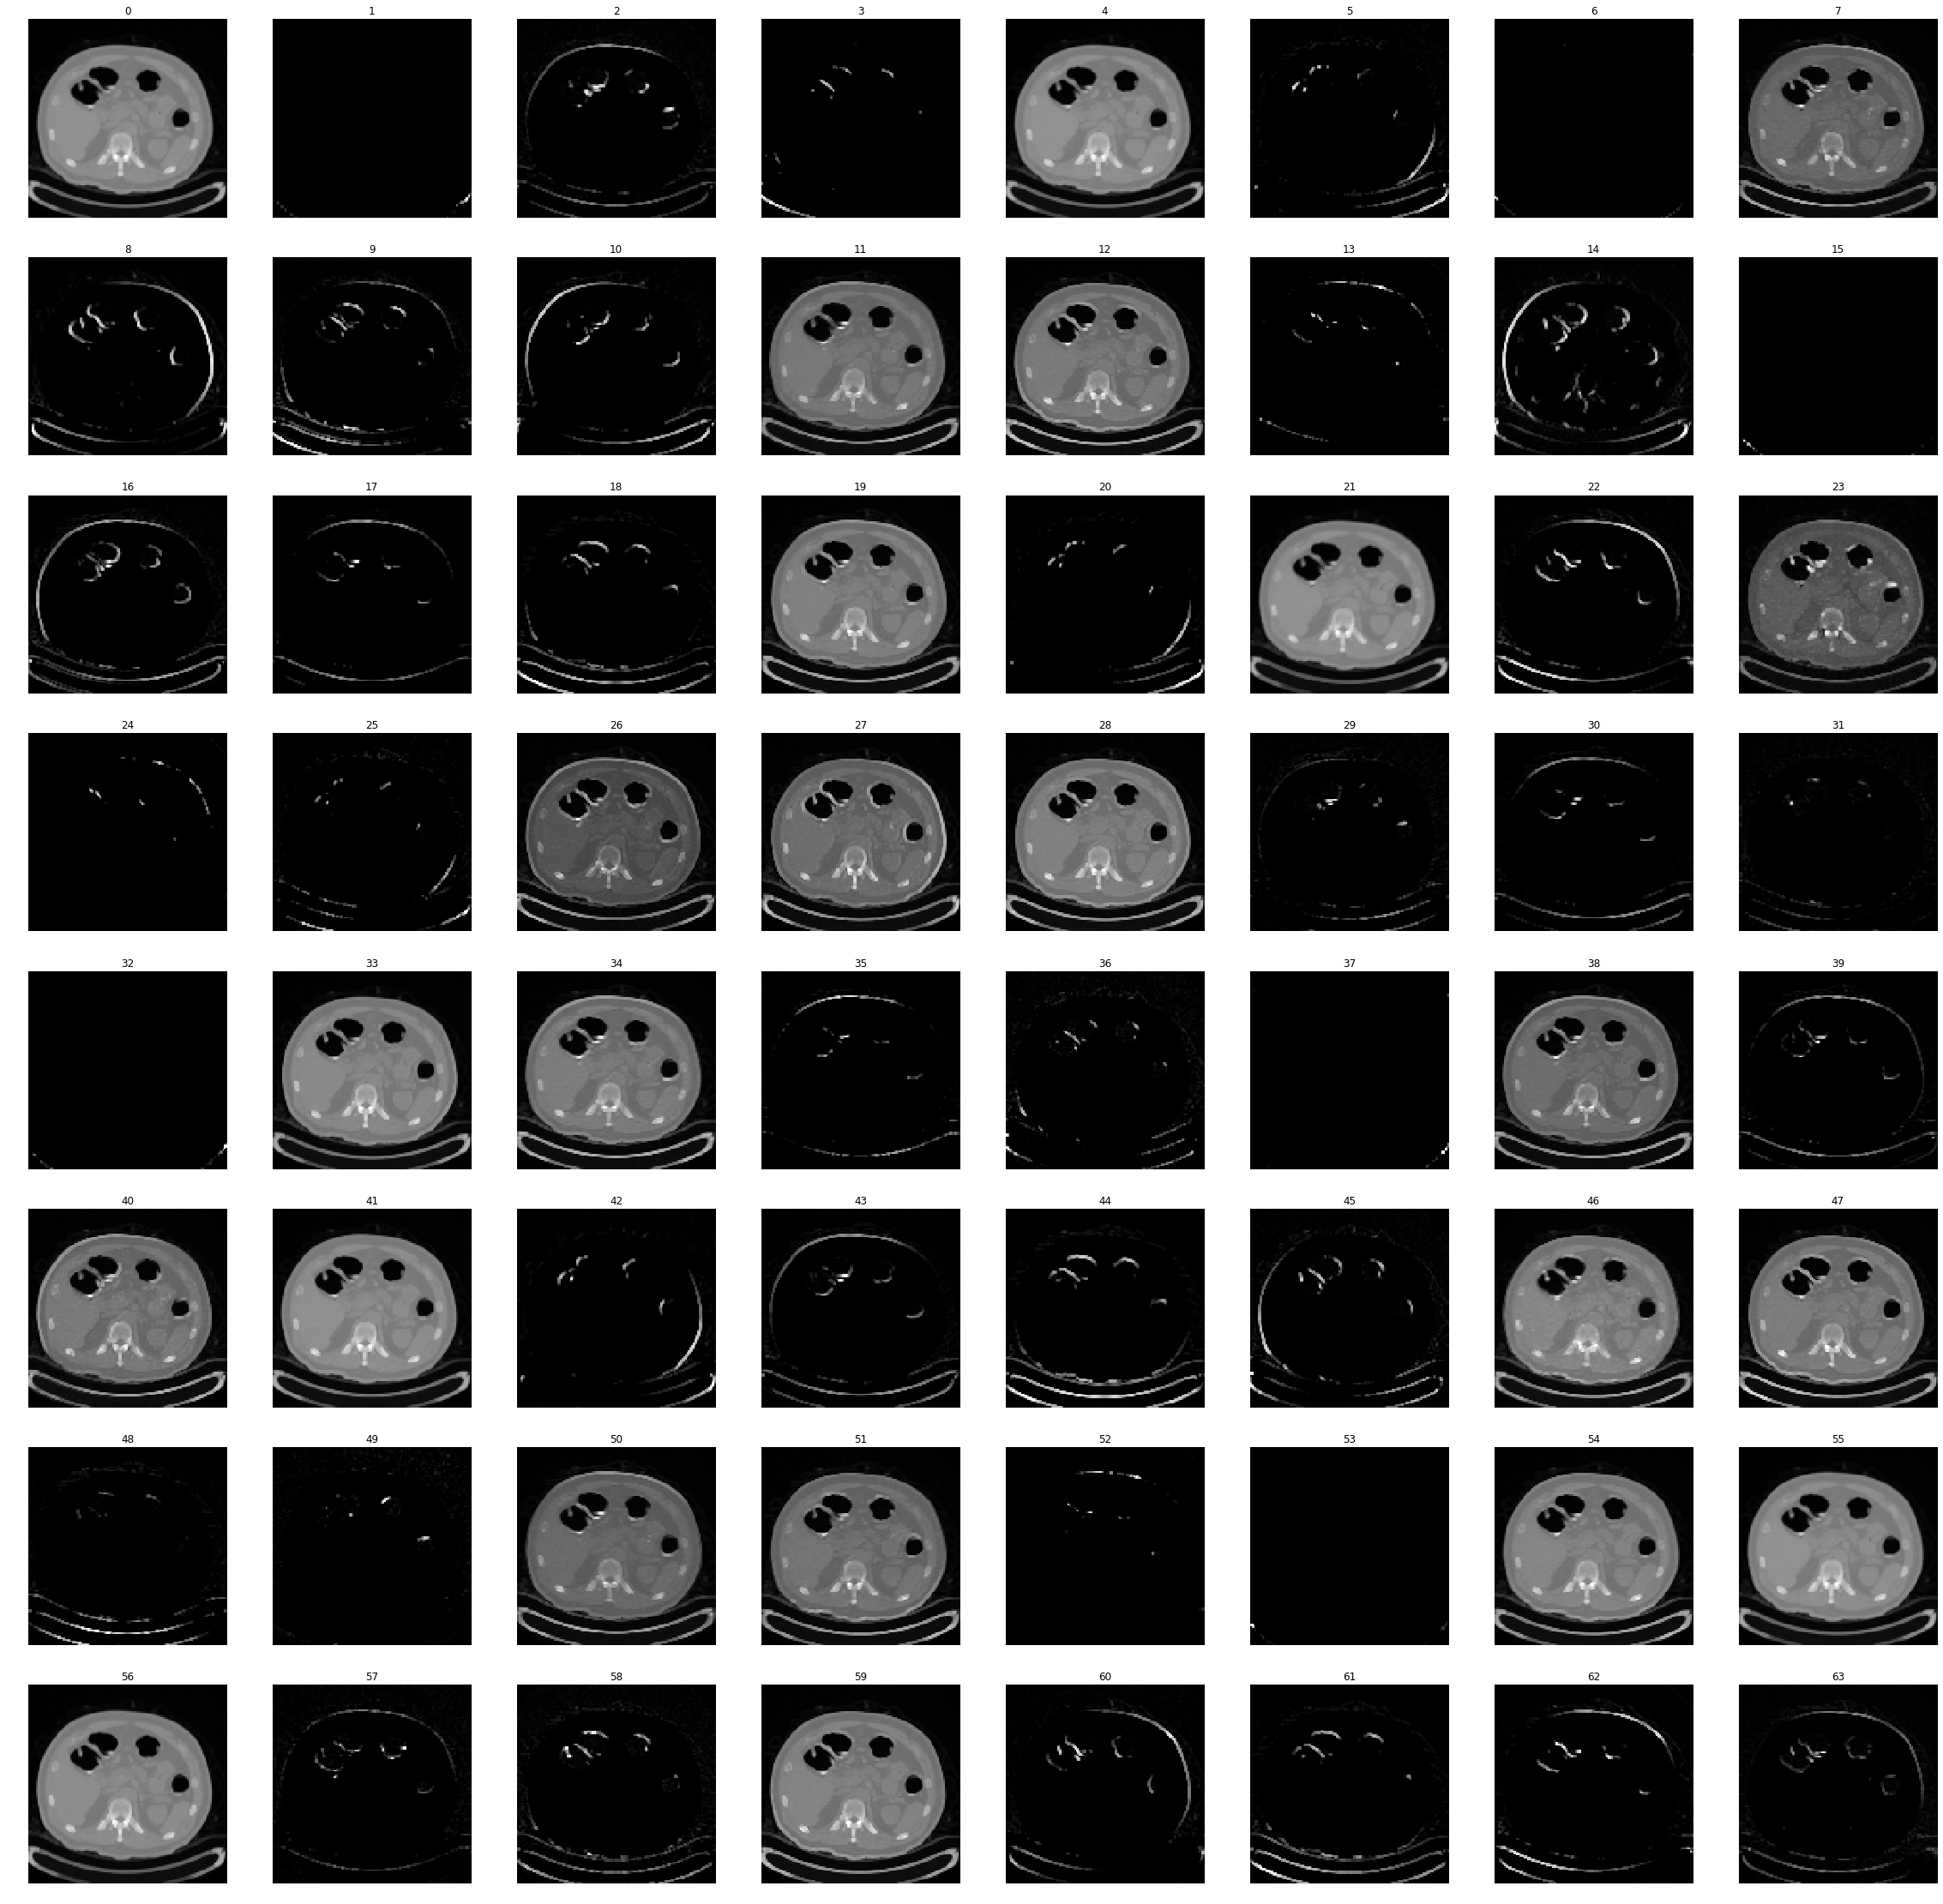

In [13]:
out = model.conv1(testimg)
out = F.relu(out)
out = F.max_pool2d(out, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
print(out.shape)
# Feature maps from first layer of the Resnet-18 from scratch
res = np.squeeze(out.detach().cpu().numpy(), 0)
fig, axes = plt.subplots(8,8, figsize=(40,40))
for idx, ax in enumerate(axes.flat):
    ax.imshow(res[idx], cmap='gray')
    ax.set_title(str(idx))
    ax.axis('off')

### Layer 1

torch.Size([1, 64, 128, 128])


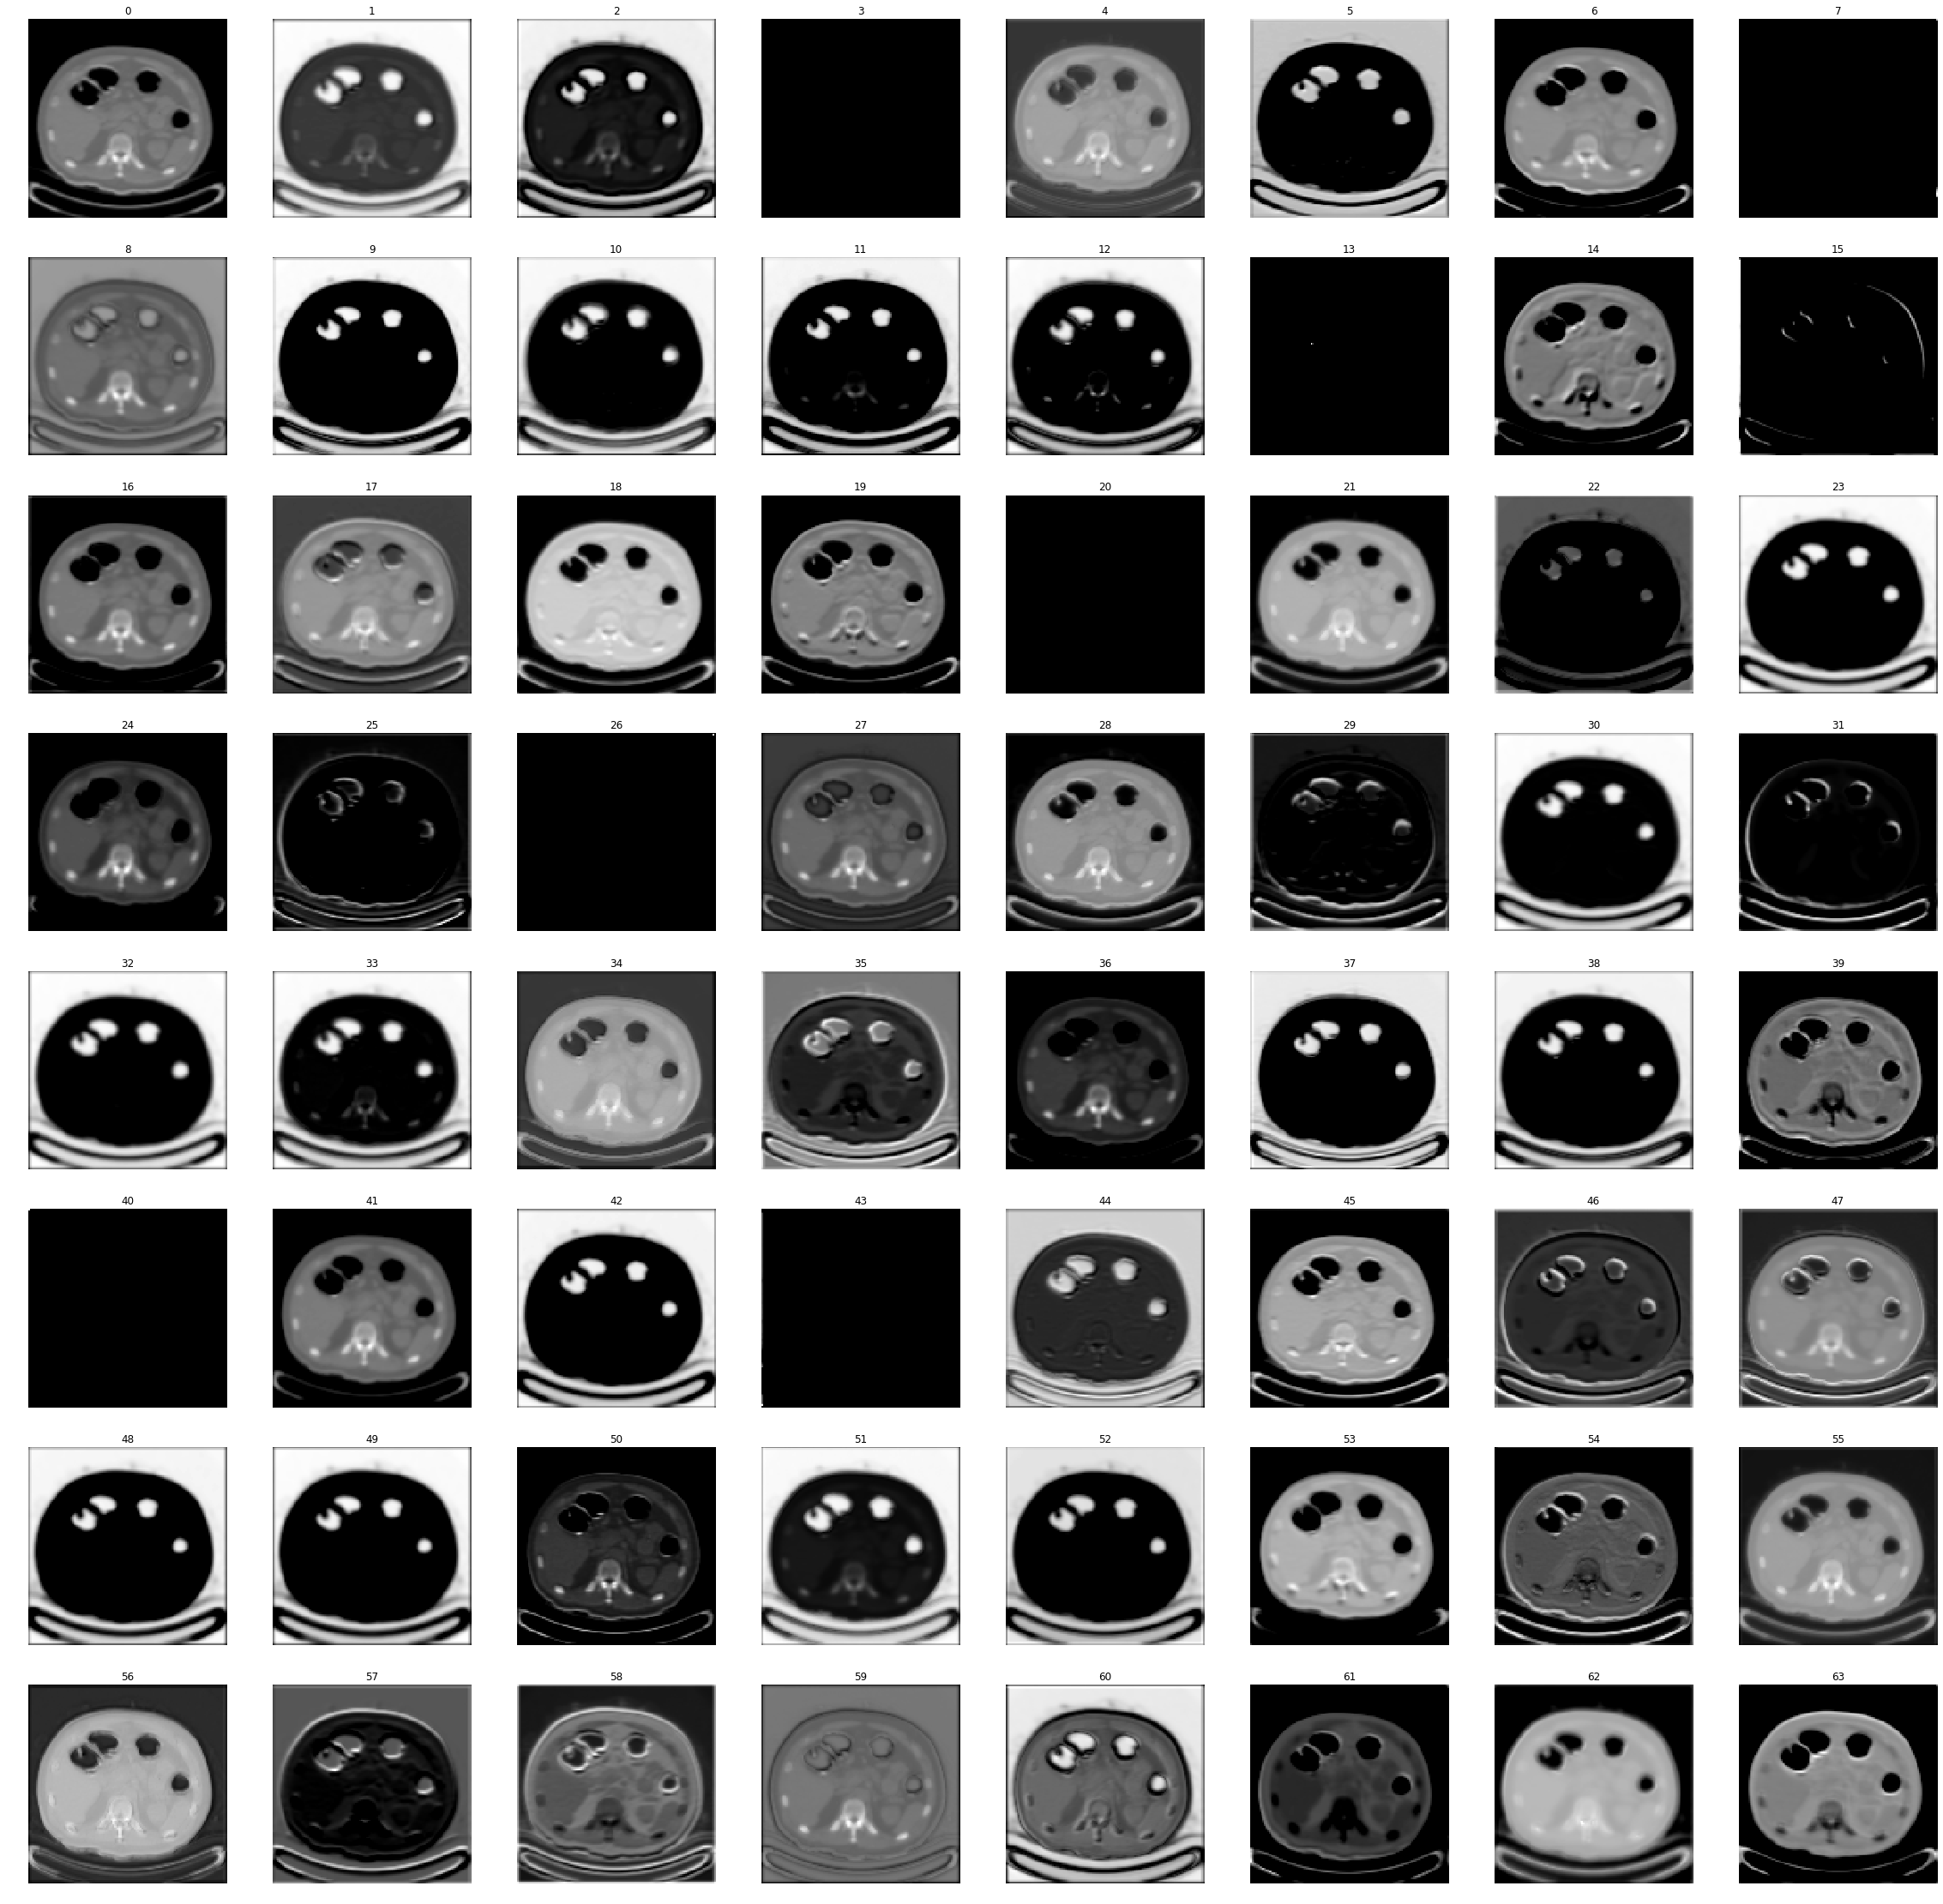

In [14]:
out = model.layer1(out)
print(out.shape)
# Feature maps from first layer of the Resnet-18 from scratch
res = np.squeeze(out.detach().cpu().numpy(), 0)
fig, axes = plt.subplots(8,8, figsize=(40,40))
for idx, ax in enumerate(axes.flat):
    ax.imshow(res[idx], cmap='gray')
    ax.set_title(str(idx))
    ax.axis('off')

### Layer 2

torch.Size([1, 128, 64, 64])


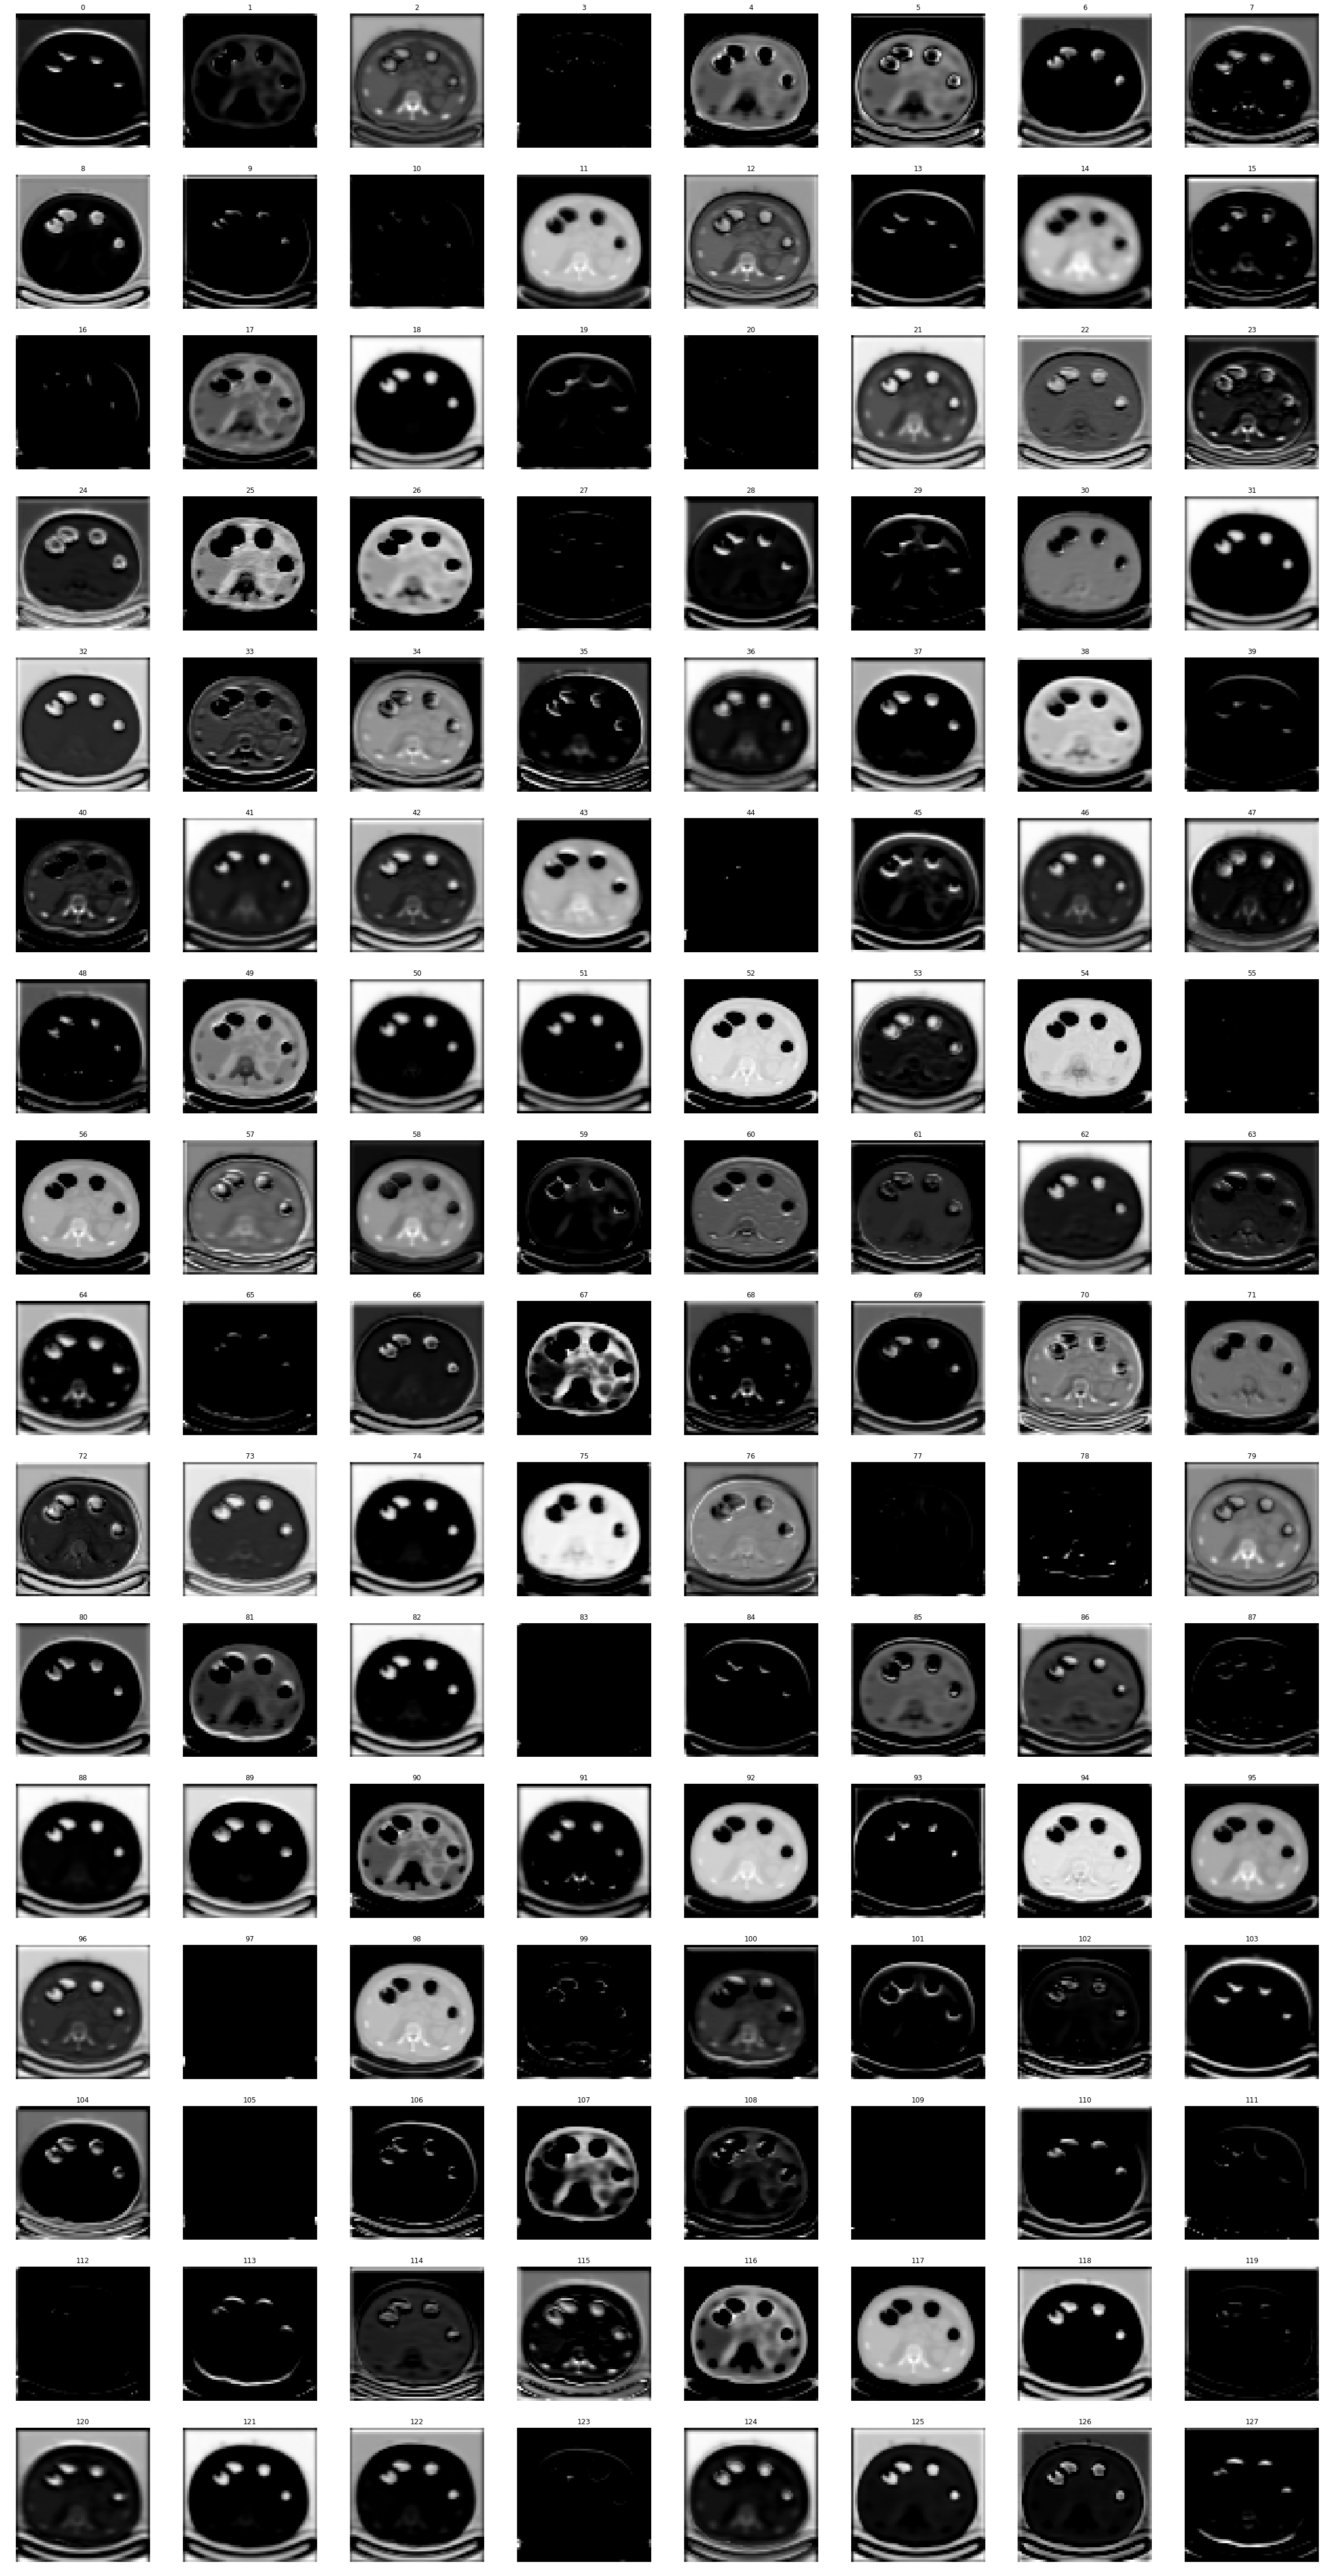

In [15]:
out = model.conv1(testimg)
out = F.relu(out)
out = F.max_pool2d(out, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
out = model.layer1(out)
out = model.layer2(out)
print(out.shape)
# Feature maps from first layer of the Resnet-18 from scratch
res = np.squeeze(out.detach().cpu().numpy(), 0)
fig, axes = plt.subplots(16,8, figsize=(40,80))
for idx, ax in enumerate(axes.flat):
    ax.imshow(res[idx], cmap='gray')
    ax.set_title(str(idx))
    ax.axis('off')

### Layer 3

torch.Size([1, 256, 32, 32])


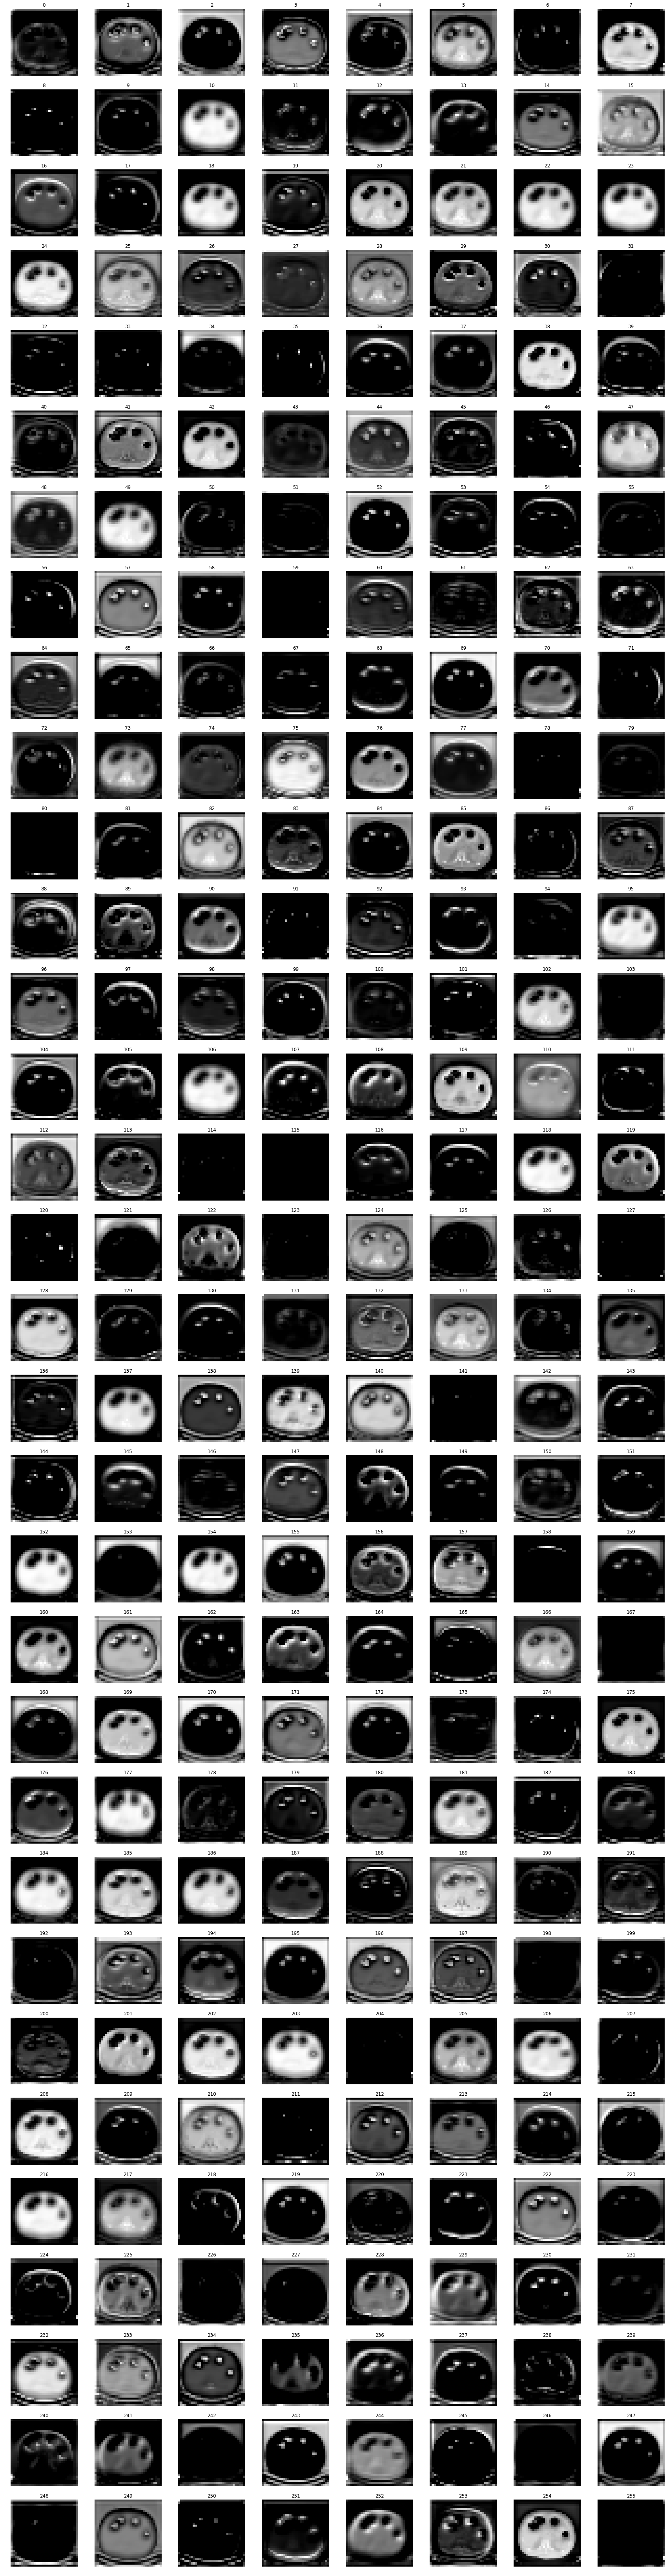

In [16]:
out = model.conv1(testimg)
out = F.relu(out)
out = F.max_pool2d(out, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
out = model.layer1(out)
out = model.layer2(out)
out = model.layer3(out)
print(out.shape)
# Feature maps from first layer of the Resnet-18 from scratch
res = np.squeeze(out.detach().cpu().numpy(), 0)
fig, axes = plt.subplots(32,8, figsize=(30,120))
for idx, ax in enumerate(axes.flat):
    ax.imshow(res[idx], cmap='gray')
    ax.set_title(str(idx))
    ax.axis('off')

### Layer 4

torch.Size([1, 512, 16, 16])


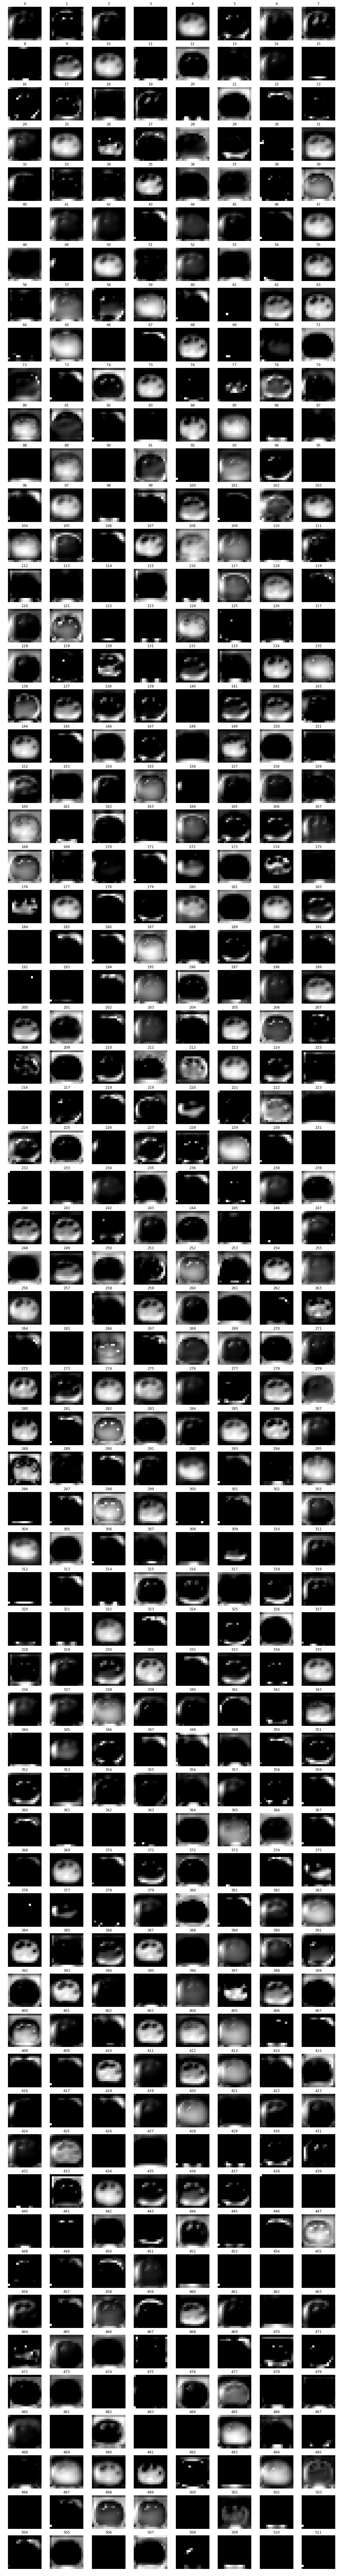

In [17]:
out = model.conv1(testimg)
out = F.relu(out)
out = F.max_pool2d(out, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
out = model.layer1(out)
out = model.layer2(out)
out = model.layer3(out)
out = model.layer4(out)
print(out.shape)
# Feature maps from first layer of the Resnet-18 from scratch
res = np.squeeze(out.detach().cpu().numpy(), 0)
fig, axes = plt.subplots(64,8, figsize=(20,160))
for idx, ax in enumerate(axes.flat):
    ax.imshow(res[idx], cmap='gray')
    ax.set_title(str(idx))
    ax.axis('off')